In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy
import pickle
import torch
import torch.nn as nn
import time
import sympy as sy
import imageio
import glob 

# Add source and data file paths
import os
path = os.path.abspath(os.getcwd())
os.chdir("../..")
parent_path = os.path.abspath(os.getcwd())

import sys 
sys.path.insert(1, parent_path + '\\source')
sys.path.insert(2, parent_path + '\\data')

# Import helper classes/functions
from network_helper import Net, MH_PINN_reg
from data_helper import pde_exact
from misc_helper import animation, training_results, knw_log, competitive_plot
from knw_helper import coeff, K_n_width

# Step 1: Load in and visualize data

In [2]:
PDE = 'poisson'

with open(parent_path + '\\data\\' + 'poisson1D_dict.pickle', 'rb') as handle:
    poisson1D_dict = pickle.load(handle)

u_ls = np.array(poisson1D_dict['u'])
f_ls = np.array(poisson1D_dict['f'])
x = poisson1D_dict['x']
xb = np.array([-1,1])

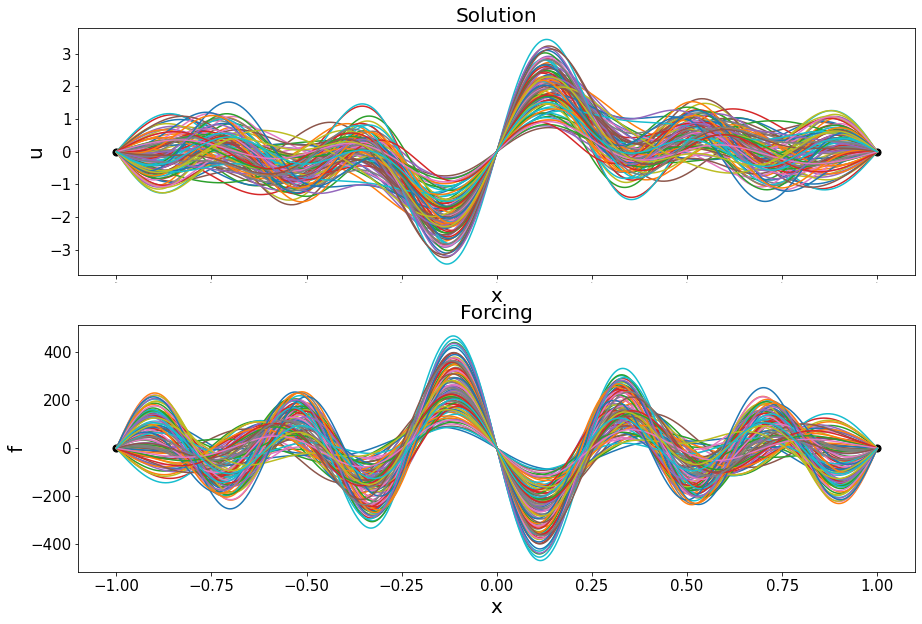

In [3]:
# Plot
plt.figure(figsize = (15,10))
for i in range(len(u_ls)):
    plt.subplot(2,1,1)
    plt.plot(x, u_ls[i])
    plt.subplot(2,1,2)
    plt.plot(x, f_ls[i])
    
plt.subplot(2,1,1)
plt.scatter(xb,xb*0, c ='k', s = 50)
plt.ylabel('u', fontsize=20); plt.xlabel('x', fontsize=20); plt.title('Solution', fontsize=20);
plt.xticks(fontsize=0); plt.yticks(fontsize=15); 
plt.subplot(2,1,2)
plt.scatter(xb,xb*0, c ='k', s = 50)
plt.ylabel('f', fontsize=20); plt.xlabel('x', fontsize=20); plt.title('Forcing', fontsize=20);
plt.xticks(fontsize=15); plt.yticks(fontsize=15);

# Step 2: Initialize and train multitask model

In [8]:
torch.manual_seed(0); np.random.seed(0)

# MH-PINN
model_name = 'hydra_sine_reg'
number_of_cases = 20
body_layers = [1, 20, 20]; head_layers = [20, 1]; act = 'sin';
verbose = 1; epoch = 1000
model_mhpinn = MH_PINN_reg(x, f_ls, xb, body_layers, head_layers, verbose, epoch, number_of_cases, act, PDE)

In [9]:
print('MH-PINN')
start_time = time.time()
# Adam training
print('Train Adam:')
model_mhpinn.train_adam()
# LBFGS training
print('Train L-BFGS:')
# Optimization Hyperparameters for LBFGS
lr = 0.1; max_iter = 5000; max_eval = None; tolerance_grad = -1; tolerance_change = -1; history_size = 50;
model_mhpinn.train_lbfgs(lr, max_iter, max_eval, tolerance_grad, tolerance_change, history_size)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

MH-PINN
Train Adam:
epoch 0, total loss: 265967
epoch 0, Kwn loss: 290.925
epoch 100, total loss: 265708
epoch 100, Kwn loss: 216.197
epoch 200, total loss: 265335
epoch 200, Kwn loss: 223.491
epoch 300, total loss: 264379
epoch 300, Kwn loss: 227.541
epoch 400, total loss: 255853
epoch 400, Kwn loss: 252.45
epoch 500, total loss: 219687
epoch 500, Kwn loss: 218.129
epoch 600, total loss: 28385.3
epoch 600, Kwn loss: 205.622
epoch 700, total loss: 15181.2
epoch 700, Kwn loss: 123.432
epoch 800, total loss: 10060.2
epoch 800, Kwn loss: 65.5602
epoch 900, total loss: 6877.96
epoch 900, Kwn loss: 43.3056
Knw: tensor(9.5290)
Train L-BFGS:
total loss:68.7454
Kwn loss: 57.6266
total loss:24.3921
Kwn loss: 10.7951
total loss:6.67751
Kwn loss: 1.86786
total loss:4.89121
Kwn loss: 1.41445
total loss:3.7597
Kwn loss: 1.01375
total loss:3.32532
Kwn loss: 0.845627
total loss:2.97418
Kwn loss: 0.576842
total loss:2.50767
Kwn loss: 0.257575
total loss:2.23461
Kwn loss: 0.157686
total loss:2.04669
Kw

# Step 3: Visualize training results

Relative L2 Error (mean): 0.009720942613074284
Relative L2 Error (std): 0.004530067230520628
Relative L2 Error (median): 0.009454823391084936
Relative L2 Error (min-max): [0.001971331225922104, 0.018320423537968592]
2-Norm Error (mean): 0.1803541815081536
2-Norm Error (std): 0.09231835618267069


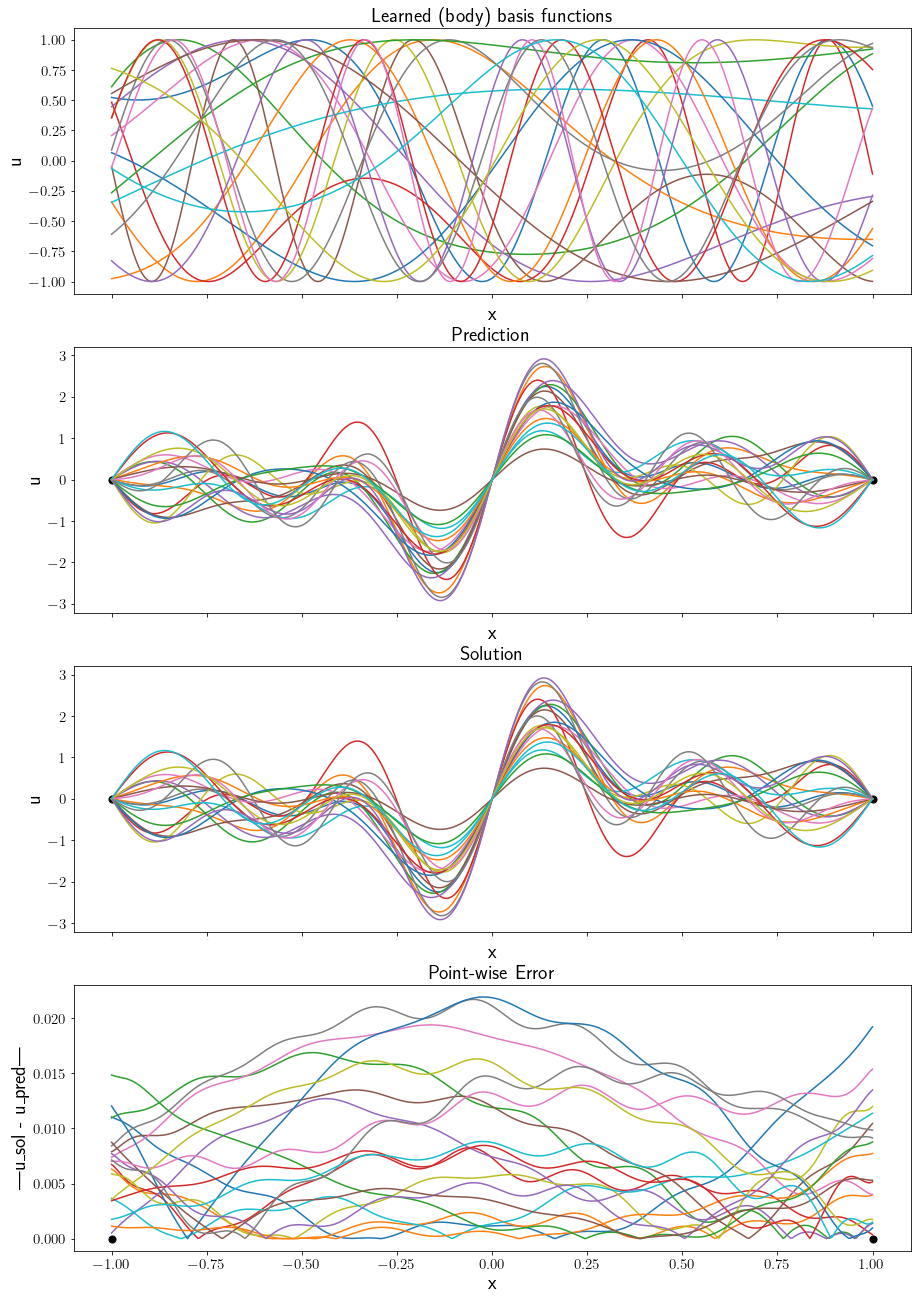

In [10]:
# Predictions
mhpinn_u_pred, basis = model_mhpinn.predict(x)
# Call helper function
l2_error_ls = training_results(number_of_cases, x, xb, u_ls, mhpinn_u_pred, basis, body_layers, path, model_name)

# Step 4: Compute K n-width metric

In [11]:
# Competative optimization
exact = pde_exact() # Needed for error estimate
solution_basis = np.array([np.sin(x*np.pi), np.sin(2*x*np.pi), np.sin(3*x*np.pi), np.sin(4*x*np.pi), np.sin(5*x*np.pi)])
model_basis = basis.numpy().T

In [12]:
def animation(path, model_name, fig_num, x, u_c_optimized, u_W1_optimized):
    plt.figure(figsize = (6.4,4.8))
    plt.gcf().set_size_inches(6.4,4.8)
    plt.plot(x,u_c_optimized.detach().numpy(),'k--',linewidth=2)
    plt.plot(x,u_W1_optimized.detach().numpy(),'r')
    plt.ylabel('u', fontsize=20); plt.xlabel('x', fontsize=20);
    plt.xticks(fontsize=10); plt.yticks(fontsize=10); plt.legend(['u(c)', 'u(W1,W2)'])
    
    plt.savefig(path + '\\figures\\' + model_name + '_animate_' + str(fig_num), dpi = 300)
    plt.close()
    return

In [13]:
# Create bi-optimization problem
torch.manual_seed(0); np.random.seed(0)
verbose = 0; adam_lr = 0.001; animate = 0; comp_plot = 1
KnW = K_n_width(solution_basis, model_basis, adam_lr, verbose, exact, 0, None, None)

In [14]:
# Training and animation
epochs = 5000
gif_num = 100; subepoch = int(epochs/gif_num)
log = knw_log()

fig_num = 0
for i in range(gif_num):
    u_c_optimized, u_W1_optimized, u_c_coeff, u_W1_coeff = KnW.solution()
    log.add(x, u_c_optimized, u_W1_optimized)
    if animate == 1:
        animation(path, model_name, fig_num, x, u_c_optimized, u_W1_optimized)
    KnW.train_adam(subepoch)
    fig_num += 1

knw_metric = KnW.metric().detach().numpy()
knw_l2_error = np.linalg.norm(u_c_optimized.detach().numpy()-u_W1_optimized.detach().numpy(), 2)/np.linalg.norm(u_c_optimized.detach().numpy(), 2)
print('KnW Metric:', knw_metric)
print('KnW Rel L2 Error:', knw_l2_error)

KnW Metric: 0.21168644811812426
KnW Rel L2 Error: 0.008435396515428845


In [15]:
if animate == 1:
    impath = glob.glob(path + '\\figures\\' + model_name + '_animate_' + '*.png')
    images = [];
    for filename in impath:
        images.append(imageio.imread(filename))
    imageio.mimsave(path + '\\figures\\' + model_name + '.mp4', images, macro_block_size = 1)
    
if comp_plot == 1:
    competitive_plot(path, model_name, log.report(), len(log.report())-1)

In [16]:
# Save data
log_dict = {'l2_error_ls': l2_error_ls, 'knw_l2_error': knw_l2_error}

with open(path + '\\log\\' + model_name + '_log_dict.pickle', 'wb') as handle:
    pickle.dump(log_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)